In [1]:
import numpy as np
import pandas as pd
from keras.models import Model, load_model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, add, concatenate, Dropout
from keras.layers import CuDNNLSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM
from keras.preprocessing import text, sequence
from gensim.models import KeyedVectors
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

Using TensorFlow backend.


In [2]:
from sklearn.utils import resample
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
import matplotlib.pyplot as plt
def plot_metric(history, EPOCHS):
    epo = list(range(EPOCHS))
    plt.plot(epo, history['loss'], label='Training loss')
    plt.plot(epo, history['val_loss'], label='Validation loss', linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epo)
    plt.legend()
    plt.show()

In [4]:
""" Title: Scikit-learn: How to obtain True Positive, True Negative, False Positive and False Negative
Author: invoketheshell, & Rasoul
Date: 2015
Availability: https://stackoverflow.com/questions/31324218/scikit-learn-how-to-obtain-true-positive-true-negative-false-positive-and-fal """
def perf_measure(y_actual, y_hat):
    y_actual = y_actual.to_list()
    y_hat = y_hat.to_list()
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1: TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]: FP += 1
        if y_actual[i]==y_hat[i]==0: TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]: FN += 1
    return(TP, FP, TN, FN)

In [6]:
EMBEDDING_FILES = [
    'crawl-300d-2M.gensim',
    'glove.840B.300d.gensim'
]
BATCH_SIZE = 512
LSTM_UNITS = 128 # output vector dimension of each lstm cell
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
EPOCHS = 20
DROPOUT_RATE = 0.5
TRAIN_PERCENT = 0.8
VALID_PERCENT = 0.25 # 25% from the training set is equiv to 20% from the whole dataset
TEXT_COLUMN = 'comment_text'
TARGET_COLUMN = 'target'

In [7]:
""" Title: Simple LSTM
Author: thousandvoices
Date: 2019
Code version: 8
Availability: https://www.kaggle.com/thousandvoices/simple-lstm?scriptVersionId=16109977 """
def build_matrix(word_index, path):
    unknown_words = []
    embedding_index = KeyedVectors.load(path, mmap='r')
    embedding_matrix = np.zeros((MAX_FEATURES + 1, 300))
    for word, i in word_index.items():
        if i <= MAX_FEATURES:
            try:
                embedding_matrix[i] = embedding_index[word]
            except KeyError:
                try:
                    embedding_matrix[i] = embedding_index[word.lower()]
                except KeyError:
                    try:
                        embedding_matrix[i] = embedding_index[word.title()]
                    except KeyError:
                        unknown_words.append(word)
    return embedding_matrix, unknown_words

In [8]:
""" Title: Simple LSTM
Author: thousandvoices
Date: 2019
Code version: 8
Availability: https://www.kaggle.com/thousandvoices/simple-lstm?scriptVersionId=16109977 """
def build_model(embedding_matrix):
    words = Input(shape=(MAX_LEN,))
    x = Embedding(*embedding_matrix.shape, weights=[embedding_matrix], trainable=False)(words)
    x = SpatialDropout1D(DROPOUT_RATE)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x),
    ])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
    result = Dense(1, activation='sigmoid')(hidden)
    model = Model(inputs=words, outputs=[result])
    model.compile(loss='binary_crossentropy', optimizer='adam') #reset learning rate using Adam Optimizer 

    return model

In [9]:
df = pd.read_csv('comments_preprocessed_1.csv', index_col = 'id')

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
print(df.memory_usage().sum() / 1024**2) # MB
print(df.shape)

40.395973205566406
(1764927, 2)


In [11]:
MAX_LEN = 242 # outter_fence
comments = df[TEXT_COLUMN].astype('str')
y = df[TARGET_COLUMN].astype(np.int8)

non_long_len = comments.apply(lambda x:len(x.split()) <= 242)
text_removelong = comments[non_long_len].copy()
non_long_len_indices = text_removelong.index
y_removelong = y.loc[non_long_len_indices].copy()

In [12]:
train_size = round(y_removelong.shape[0]*TRAIN_PERCENT)
print(train_size)

1411933


In [35]:
x_train = text_removelong[:train_size,]
y_train = y_removelong[:train_size,]
x_test = text_removelong[train_size:,]
y_test = y_removelong[train_size:,]

In [36]:
text_removelong[:train_size,]

id
59848      this be so cool -PRON- be like ' would -PRON- ...
59849      thank -PRON- this would make -PRON- life a lot...
59852      this be such an urgent design problem kudo to ...
59855      be this something i will be able to install on...
59856                    haha -PRON- guy be a bunch of loser
                                 ...                        
5882858    i ' m with -PRON- on most of that the only exc...
5882859    as someone who experience sept in low manhatta...
5882860    stampoutignorance -PRON- comment be spot on un...
5882861    just have the girl take a small cut from each ...
5882862                                     so sell and move
Name: comment_text, Length: 1411933, dtype: object

In [37]:
print(x_train.shape, x_test.shape)

(1411933,) (352983,)


handle imbalanced data

In [38]:
# undersample

n_toxic = sum(y_train == 1) # number of toxic comments in training set
toxic_id = y_train[y_train == 1].index
non_toxic_id = y_train[y_train == 0].index

# undersample majority class
non_toxic_undersampled_id = resample(non_toxic_id,
                                replace = False, # sample without replacement
                                n_samples = n_toxic, # match the size of toxic set
                                random_state = 34)

# combined with toxic and undersampled non-toxic instances
x_train_new = pd.concat([x_train[non_toxic_undersampled_id], x_train[toxic_id]])
y_train_new = pd.concat([y_train[non_toxic_undersampled_id], y_train[toxic_id]])

In [39]:
n_toxic

111411

In [17]:
tokenizer = text.Tokenizer(lower = False)
tokenizer.fit_on_texts(list(x_train_new) + list(x_test))

In [18]:
MAX_FEATURES = len(tokenizer.word_index)

In [19]:
x_train = tokenizer.texts_to_sequences(x_train_new)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=MAX_LEN)
x_test = sequence.pad_sequences(x_test, maxlen=MAX_LEN)

In [20]:
""" Title: Simple LSTM
Author: thousandvoices
Date: 2019
Code version: 8
Availability: https://www.kaggle.com/thousandvoices/simple-lstm?scriptVersionId=16109977 """
embedding_matrix_cl, unknown_words_cl = build_matrix(tokenizer.word_index, EMBEDDING_FILES[0])
print('n unknown words(crawl): ', len(unknown_words_cl))
embedding_matrix_gl, unknown_words_gl = build_matrix(tokenizer.word_index, EMBEDDING_FILES[1])
print('n unknown words(glove): ', len(unknown_words_gl))

embedding_matrix = np.concatenate([embedding_matrix_cl, embedding_matrix_gl], axis=-1)

del embedding_matrix_cl
del embedding_matrix_gl

embedding_matrix.shape

n unknown words(crawl):  39098
n unknown words(glove):  39342


(133305, 600)

In [21]:
""" Title: Simple LSTM
Author: thousandvoices
Date: 2019
Code version: 8
Availability: https://www.kaggle.com/thousandvoices/simple-lstm?scriptVersionId=16109977 """

# dropoutrate 0.5

model = build_model(embedding_matrix)
print('model built')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
print('es is set')
mc = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
print('mc is set')
hist = model.fit(
    x_train,
    y_train_new,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    validation_split = VALID_PERCENT,
    callbacks=[es, mc]
)
print('model fitted')
predictions = model.predict(x_test, batch_size=512).flatten()

model built
es is set
mc is set
Train on 167116 samples, validate on 55706 samples
Epoch 1/20
167116/167116 [==============================] - 1748s 10ms/step - loss: 0.3473 - val_loss: 0.3526

Epoch 00001: val_loss improved from inf to 0.35258, saving model to best_model.h5
Epoch 2/20
167116/167116 [==============================] - 1815s 11ms/step - loss: 0.2772 - val_loss: 0.2558

Epoch 00002: val_loss improved from 0.35258 to 0.25583, saving model to best_model.h5
Epoch 3/20
167116/167116 [==============================] - 1758s 11ms/step - loss: 0.2624 - val_loss: 0.2525

Epoch 00003: val_loss improved from 0.25583 to 0.25245, saving model to best_model.h5
Epoch 4/20
167116/167116 [==============================] - 1814s 11ms/step - loss: 0.2502 - val_loss: 0.4089

Epoch 00004: val_loss did not improve from 0.25245
Epoch 5/20
167116/167116 [==============================] - 1758s 11ms/step - loss: 0.2396 - val_loss: 0.3710

Epoch 00005: val_loss did not improve from 0.25245
Epoch 

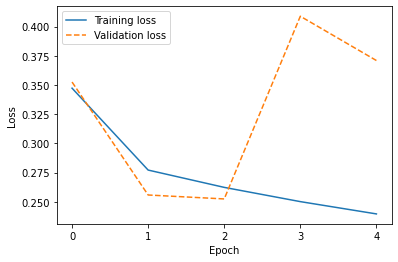

In [23]:
plot_metric(hist.history, 5)

In [24]:
predictions_encoded = pd.Series(predictions).apply(lambda x: 0 if x < 0.5 else 1)

In [25]:
y_test_pred = pd.DataFrame({'lstm_predict':predictions_encoded, 'id': list(y_test.index)})
y_result = y_test_pred.merge(y_test, left_on='id', right_on=y_test.index).set_index('id')
y_result.to_csv('result_lstm_batch512_epoch20es_undersam_nomaxf.csv')

In [27]:
print('accuracy:', accuracy_score(y_pred = y_test, y_true = predictions_encoded))
print('precision:',precision_score(y_pred = y_test, y_true = predictions_encoded))
print('recall:', recall_score(y_pred = y_test, y_true = predictions_encoded))
print('f1:', f1_score(y_pred = y_test, y_true = predictions_encoded))

accuracy: 0.902046274183176
precision: 0.8644898775973051
recall: 0.4593057253734517
f1: 0.5998889094612109


# References

Mikolov, T., Grave, E., Bojanowski, P., Puhrsch, C., & Joulin, A. (2018). Advances in Pre-Training Distributed Word Representations. International Conference on Language Resources and Evaluation.

Pennington, J., Socher, R., & Manning, C. D. (2014, August). GloVe: Global Vectors for Word Representation. Retrieved from The Stanford Natural Language Processing Group: https://nlp.stanford.edu/pubs/glove.pdf

Thousandvoices (2019). Simple LSTM (Version 8) [Source code]. https://www.kaggle.com/thousandvoices/simple-lstm/data?scriptVersionId=16109977